# MLP vs. KAN

In [140]:
import collections
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchinfo
import datasets
import kan

In [163]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [93]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # test if it worked
        x = torch.ones(1, device=device)
        print('Using CUDA device')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        x = torch.ones(1, device=device)
        print('Using MPS device')
    else:
        print('Using CPU')
        device = torch.device('cpu')
    return device
device = get_device()

Using MPS device


In [94]:
train_data = datasets.load_dataset("christopher/mnist1d", split="train")
valid_data = datasets.load_dataset("christopher/mnist1d", split="test")

train_data.set_format("torch")
valid_data.set_format("torch")

train_data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data["x"], train_data["y"]),
    batch_size=40,
    shuffle=True
)

valid_data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(valid_data["x"], valid_data["y"]),
    batch_size=40,
    shuffle=True
)

In [174]:
def train(
        data_loader: torch.utils.data.DataLoader,
        model: nn.Module,
        loss: nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device
):
    model.to(device)
    model.train()

    losses = []
    acccuracies = []

    for inputs, label in data_loader:
        inputs = inputs.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)
        loss_value = loss(predictions, label)

        loss_value.backward()
        optimizer.step()

        losses.append(loss_value.item())
        acccuracies.append(accuracy(predictions, label))

    return np.mean(losses), np.mean(acccuracies)

def validate(
    data_loader: torch.utils.data.DataLoader,
    model: nn.Module,
    loss: nn.Module,
    device: torch.device
):
    model.to(device)
    model.eval()

    losses = []
    accuracies = []

    with torch.no_grad():
        for inputs, label in data_loader:
            inputs = inputs.to(device)
            label = label.to(device)

            prediction = model(inputs)
            loss_value = loss(prediction, label)

            losses.append(loss_value.item())
            accuracies.append(accuracy(prediction, label))

    return np.mean(losses), np.mean(accuracies)

def accuracy(predictions, labels):
    predicted_classes = torch.argmax(predictions, dim=1)
    correct = (predicted_classes == labels).float()
    accuracy = correct.sum() / len(correct)
    return accuracy.item()

def input_size(data_loader: torch.utils.data.DataLoader) -> tuple:
    return tuple(next(iter(data_loader))[0].shape)

def plot_metric(
    ax: plt.Axes,
    train_metric,
    valid_metric,
    train_label: str = None,
    valid_label: str = None,
    y_label: str = None
):
    ax.plot(train_metric, label=train_label)
    ax.plot(valid_metric, label=valid_label)
    ax.set_xlabel("epoch")
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid()

In [208]:
def run_experiment(
    epochs: int,
    train_data_loader: torch.utils.data.DataLoader,
    valid_data_loader: torch.utils.data.DataLoader,
    model: nn.Module,
    loss: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device
):
    print(torchinfo.summary(model, input_size = input_size(train_data_loader)))

    metrics = collections.defaultdict(list)

    for _ in tqdm.tqdm(range(epochs)):
        train_loss, train_accuracy = train(
            train_data_loader,
            model,
            loss,
            optimizer,
            device
        )

        valid_loss, valid_accuracy = validate(
            valid_data_loader,
            model,
            loss,
            device
        )

        metrics["train_losses"].append(train_loss)
        metrics["train_accuracies"].append(train_accuracy)
        metrics["valid_losses"].append(valid_loss)
        metrics["valid_accuracies"].append(valid_accuracy)


    fig = plt.figure(figsize=(16, 4))

    plot_metric(
        fig.add_subplot(1, 2, 1),
        metrics["train_losses"],
        metrics["valid_losses"],
        train_label="training loss",
        valid_label="validation loss",
        y_label="loss"
    )

    plot_metric(
        fig.add_subplot(1, 2, 2),
        metrics["train_accuracies"],
        metrics["valid_accuracies"],
        train_label="training accuracy",
        valid_label="validation accuracy",
        y_label="accuracy"
    )

    print(f"\t\t\tBest Loss:\t\tBest Accuracy:")
    print(f"Training:\t\t{min(metrics['train_losses']):.4f}\t\t\t{max(metrics['train_accuracies']):.4f}")
    print(f"Validation:\t\t{min(metrics['valid_losses']):.4f}\t\t\t{max(metrics['valid_accuracies']):.4f}")


In [209]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(40, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        return self.layers(x)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [40, 10]                  --
├─Sequential: 1-1                        [40, 10]                  --
│    └─Linear: 2-1                       [40, 64]                  2,624
│    └─BatchNorm1d: 2-2                  [40, 64]                  128
│    └─ReLU: 2-3                         [40, 64]                  --
│    └─Linear: 2-4                       [40, 64]                  4,160
│    └─BatchNorm1d: 2-5                  [40, 64]                  128
│    └─ReLU: 2-6                         [40, 64]                  --
│    └─Linear: 2-7                       [40, 32]                  2,080
│    └─BatchNorm1d: 2-8                  [40, 32]                  64
│    └─ReLU: 2-9                         [40, 32]                  --
│    └─Linear: 2-10                      [40, 10]                  330
Total params: 9,514
Trainable params: 9,514
Non-trainable params: 0
Total

100%|██████████| 200/200 [00:59<00:00,  3.38it/s]

			Best Loss:		Best Accuracy:
Training:		0.1594			0.9438
Validation:		0.8623			0.7070


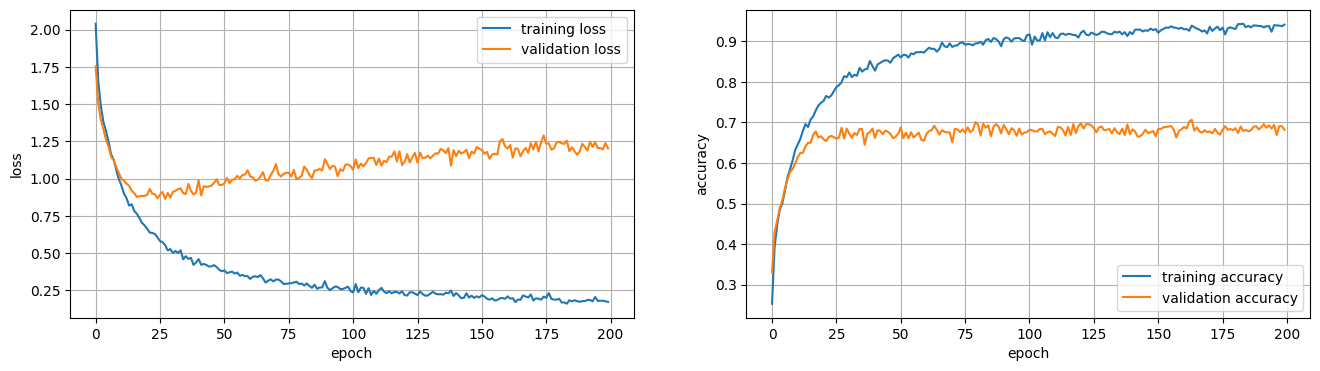

In [210]:
model = MLP()

run_experiment(
    epochs = 200,
    model = model,
    loss = nn.CrossEntropyLoss(),
    optimizer = torch.optim.Adam(model.parameters()),
    train_data_loader = train_data_loader,
    valid_data_loader = valid_data_loader,
    device = device
)